# Projecto Machine Learning

In [1]:
import matplotlib.pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15, 6)
import numpy as np
import pyGPs
from OX_database import DissolvedOxygenDatabase
from IPython.display import display
#GPy.plotting.change_plotting_library('plotly')

# Cargar base de datos

In [2]:
path = "/home/rodrigo/ml_prob/DissolvedOxygenPrediction/database/"
sequence_size = 3
train_prop = 0.75
first_day = [2007, 7, 1]

database = DissolvedOxygenDatabase(database_path=path,
                                   sequence_size=3,
                                   train_prop=train_prop,
                                   sequence_batch_size=50,
                                   start_date=first_day)

loading Dissolved_Oxygen
loading Temperature
loading pH
loading Electrical_Conductivity
loading River_Discharge


In [7]:
train_input, train_target, train_days = database.next_batch(batch_size="all")
#train_target = train_target[..., np.newaxis]
max_days = float(np.amax(train_days))
train_days = train_days/max_days
#train_days = train_days[..., np.newaxis]/max_days
test_input, test_target, test_days = database.next_batch(set="test")
test_days = test_days/max_days
#test_target = test_target[..., np.newaxis]
#test_days = test_days[..., np.newaxis]/max_days
extend_train_days = np.linspace(-0.15, 1.15, 200)
print(train_target.shape, train_days.shape)

((1661,), (1661,))


## Relación entre variables

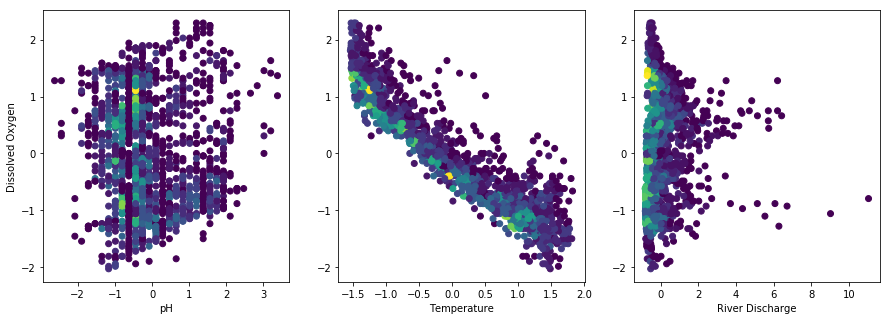

In [4]:
t_target = train_target
n_points = 40

f, axarr = plt.subplots(1,3, figsize=(15,5))
xedges, yedges = np.linspace(np.amin(train_input[:, 0]), np.amax(train_input[:, 0]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 0], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 0], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[0].scatter(train_input[:, 0], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[0].set_xlabel("pH")
axarr[0].set_ylabel("Dissolved Oxygen")

xedges, yedges = np.linspace(np.amin(train_input[:, 1]), np.amax(train_input[:, 1]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 1], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 1], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[1].scatter(train_input[:, 1], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[1].set_xlabel("Temperature")

xedges, yedges = np.linspace(np.amin(train_input[:, 2]), np.amax(train_input[:, 2]), n_points), np.linspace(-2, 2, n_points)
hist, xedges, yedges = np.histogram2d(train_input[:, 2], t_target, (xedges, yedges))
xidx = np.clip(np.digitize(train_input[:, 2], xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(t_target, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
sc = axarr[2].scatter(train_input[:, 2], t_target, c=c)
#plt.colorbar(sc, orientation='horizontal')
axarr[2].set_xlabel("River Discharge")
plt.show()

## Kernel exponencial

[0.0, 0.0, 0.0]


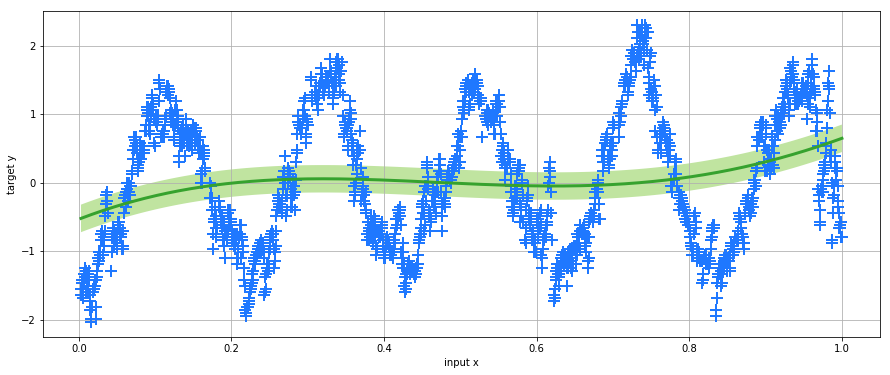

In [5]:
model = pyGPs.GPR()
sigma_noise = 1.0
sigma_rbf = 1.0
l_rbf = 1.0
k = pyGPs.cov.RBF(log_sigma=np.log(sigma_rbf), log_ell=np.log(l_rbf)) + pyGPs.cov.Const(log_sigma=np.log(sigma_noise))
model.setPrior(kernel = k)
print(model.covfunc.hyp)
model.getPosterior(train_days, train_target)
model.predict(train_days)
model.plot()

In [8]:
model.optimize(train_days, train_target)

No handlers could be found for logger "pyGPs.Core.opt"


-440.493343133
[  1.93079660e-03   7.55033387e-01   3.29262979e-05]


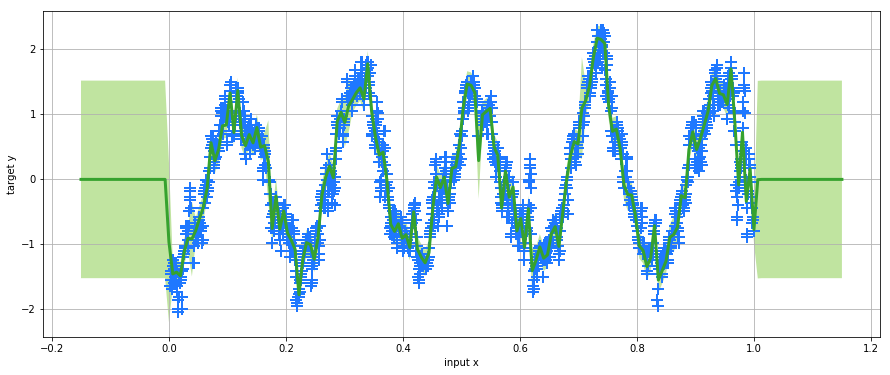

In [9]:
print(model.nlZ)
print(np.exp(model.covfunc.hyp))
extend_train_days = np.linspace(-0.15, 1.15, 200)
model.predict(extend_train_days)
model.plot()

## Periodic Kernel

[3.2559674416535049, -0.88848005252013629, 8.9446594520226945, -2.3576174188103183]
6599.72375102


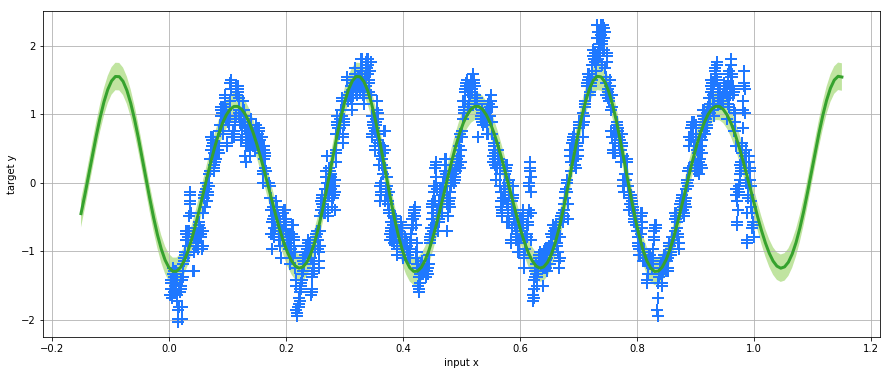

In [8]:
periodic_model = pyGPs.GPR()
sigma_noise = 0.0946454552543
kernel_variance = np.log(7666.83721954)
kernel_scale = np.log(25.9447023823)
period = np.log(0.411280402526)

periodic_k = pyGPs.cov.Periodic(log_p=period, log_ell=kernel_scale, log_sigma=kernel_variance) + pyGPs.cov.Const(log_sigma=np.log(sigma_noise))
periodic_model.setPrior(kernel = periodic_k)
print(periodic_model.covfunc.hyp)
periodic_model.getPosterior(train_days, train_target)
periodic_model.predict(extend_train_days)
print(periodic_model.nlZ)
periodic_model.plot()

In [25]:
min_threshold = 440.0

periodic_model.setOptimizer(method="Minimize", min_threshold=440.0)
periodic_model.optimize(train_days, train_target)

-440.277223152
[ 0.00998434  1.21327966  0.75304351  0.00210297]


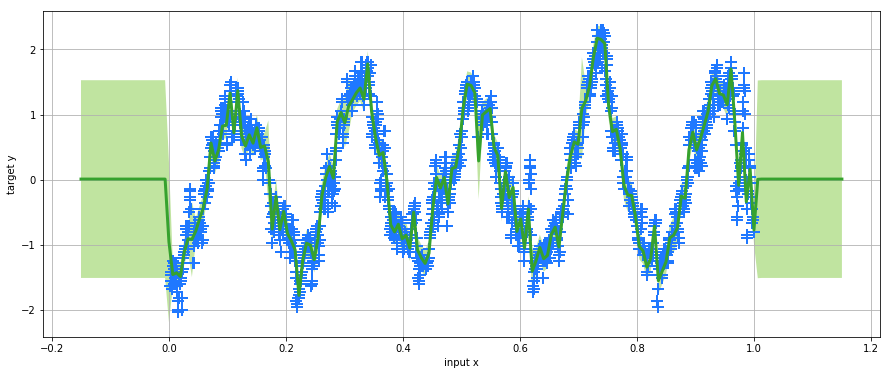

In [28]:
print(periodic_model.nlZ)
print(np.exp(periodic_model.covfunc.hyp))
extend_train_days = np.linspace(-0.15, 1.15, 200)
periodic_model.predict(extend_train_days)
periodic_model.plot()

In [9]:
def plot_mean_std(x, mean, std, real):
    fig = plt.figure()
    print(x.shape)
    print(mean.shape)
    print(std.shape)
    plt.plot(x, mean, "b", label = "Mean")
    mean = np.reshape(mean, (mean.shape[0],))
    x = np.reshape(x, (x.shape[0],))
    std = np.reshape(std, (std.shape[0],))
    real = np.reshape(real, (std.shape[0],))
    plt.fill_between(x, mean+2*std, mean-2*std, alpha = 0.3)
    plt.plot(x, real, 'x')
    plt.show()

(563,)
(563, 1)
(563, 1)


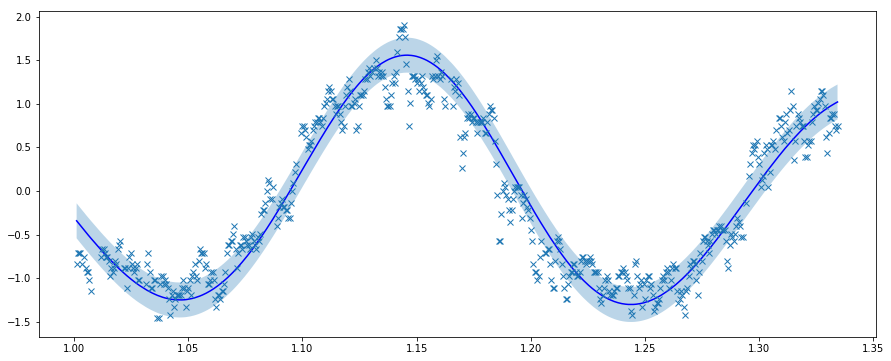

In [10]:
ym, ys2, fm, fs2, lp = periodic_model.predict(test_days)
plot_mean_std(test_days, ym, np.sqrt(ys2), test_target)

## Sum of periodic kernels

In [56]:
def sum_periodic_kernel(n_kernels=5):
    k = pyGPs.cov.Periodic()
    for i in range(n_kernels-1):
        k += pyGPs.cov.Periodic()
    k += pyGPs.cov.Const()
    return k

8444.08395965


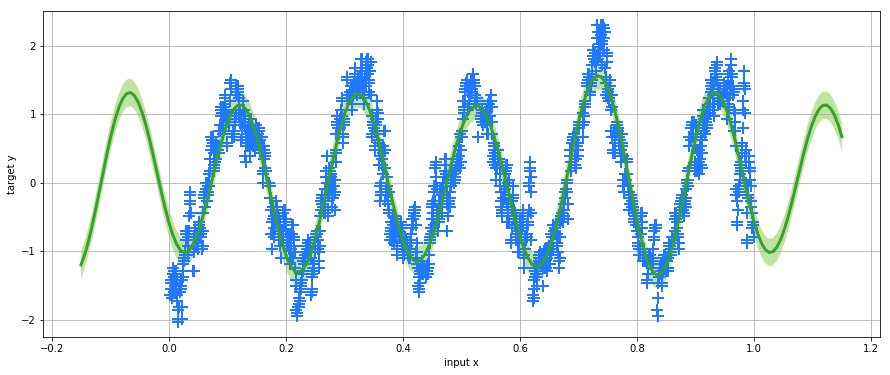

In [57]:
sum_periodic_kernel = sum_periodic_kernel(5)
sum_periodic_model = pyGPs.GPR()
sum_periodic_model.setPrior(kernel = sum_periodic_kernel)
sum_periodic_model.getPosterior(train_days, train_target)
sum_periodic_model.predict(extend_train_days)
print(sum_periodic_model.nlZ)
sum_periodic_model.plot()

In [64]:
sum_periodic_model.optimize(train_days, train_target, numIterations=30)

-438.88543182
[ 0.01125059  1.07910428  0.33676465  0.01125059  1.07910428  0.33676465
  0.01125059  1.07910428  0.33676465  0.01125059  1.07910428  0.33676465
  0.01125059  1.07910428  0.33676465  0.08762986]


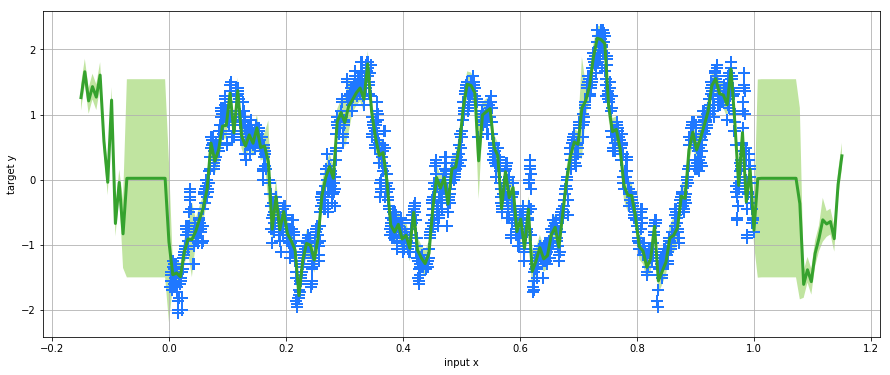

In [65]:
print(sum_periodic_model.nlZ)
print(np.exp(sum_periodic_model.covfunc.hyp))
extend_train_days = np.linspace(-0.15, 1.15, 200)
sum_periodic_model.predict(extend_train_days)
sum_periodic_model.plot()

(563,)
(563, 1)
(563, 1)


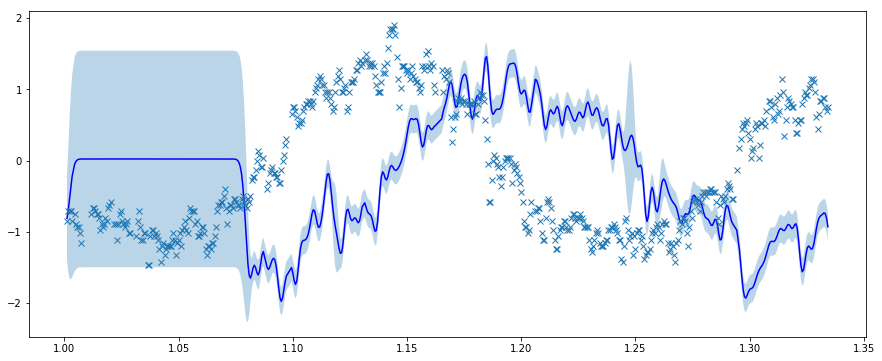

In [66]:
ym, ys2, fm, fs2, lp = sum_periodic_model.predict(test_days)
plot_mean_std(test_days, ym, np.sqrt(ys2), test_target)

## Spectral Mixture

540.11295442


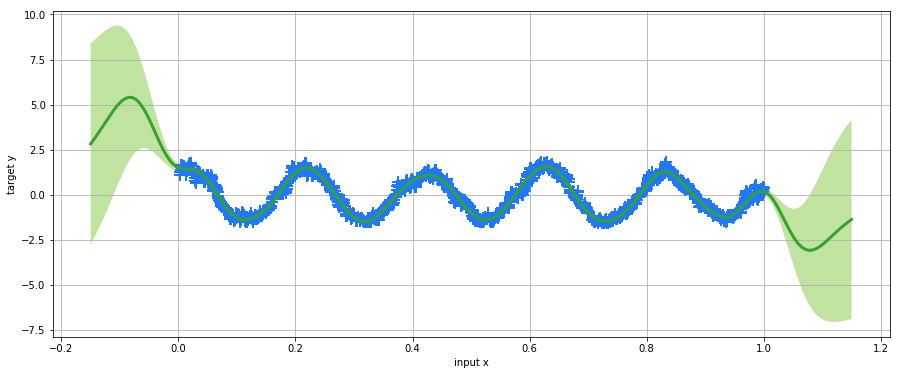

In [36]:
SM_model = pyGPs.GPR()

SM_kernel = pyGPs.cov.SM(Q=5, D=1)
#SM_kernel.initSMhypers(train_days, train_target)
SM_model.setPrior(kernel = SM_kernel)
hyp = SM_model.covfunc.hyp.tolist()
SM_kernel = pyGPs.cov.SM(Q=5, hyps=hyp) + pyGPs.cov.Const()
SM_model.setPrior(kernel = SM_kernel)
#print(type(SM_model.covfunc.hyp))
SM_model.getPosterior(train_days, train_input[:,1])
SM_model.predict(extend_train_days)
print(SM_model.nlZ)
SM_model.plot()

In [37]:
SM_model.optimize(train_days, train_input[:,1], numIterations=5)

-1367.1754402
[  2.49923491   1.03336318   1.09267056   2.26714031   1.1215269
   1.56191235   1.46060124   1.62736502   1.09459695   6.8664979
   1.40838805   1.21448823   1.87309966   1.01083555  86.95300399
   0.98509588]


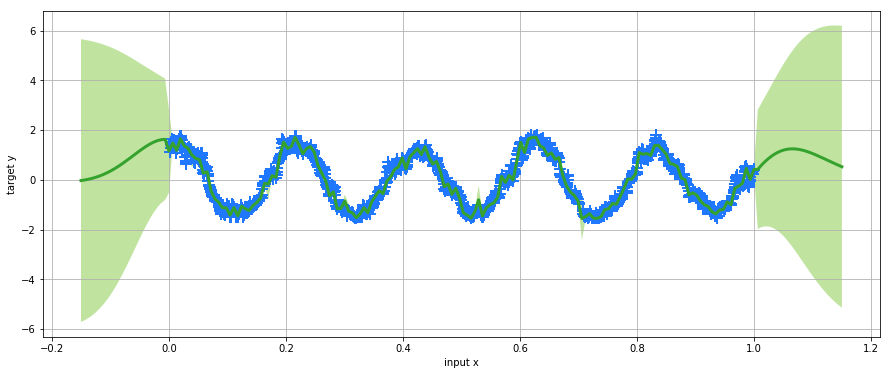

In [38]:
print(SM_model.nlZ)
print(np.exp(SM_model.covfunc.hyp))
extend_train_days = np.linspace(-0.15, 1.15, 200)
SM_model.predict(extend_train_days)
SM_model.plot()